In [1053]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

In [1054]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [1055]:
epoch_key = ('bon', 4, 2)

In [4]:
from src.parameters import ANIMALS, SAMPLING_FREQUENCY

In [5]:
from loren_frank_data_processing.position import (
    get_interpolated_position_dataframe, get_position_dataframe, get_linear_position_structure)

interpolated_position_df = get_interpolated_position_dataframe(epoch_key, ANIMALS)
position_df = get_position_dataframe(epoch_key, ANIMALS)
linear_position_df = get_linear_position_structure(epoch_key, ANIMALS)

In [6]:
linear_position_df.head(5)

,linear_distance,trajectory_category_ind
time,,
00:41:01.011300,27.764715,0
00:41:01.044700,26.866609,0
00:41:01.078100,25.519451,0
00:41:01.111400,24.621346,0
00:41:01.144800,23.274188,0


In [7]:
position_df.head(5)

,x_position,y_position,head_direction,speed
time,,,,
00:41:01.011300,216.9,112.05,1.570796,33.533748
00:41:01.044700,216.9,112.95,1.570796,33.533748
00:41:01.078100,216.9,114.30,1.570796,33.508012
00:41:01.111400,216.9,115.20,1.570796,33.556168
00:41:01.144800,216.9,116.55,1.570796,33.375128


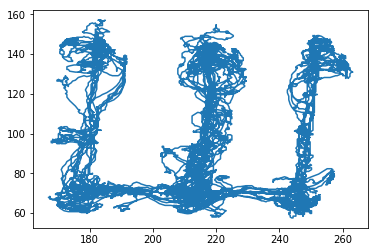

In [8]:
plt.plot(position_df.x_position, position_df.y_position)

In [9]:
linear_position_df.head(5)

,linear_distance,trajectory_category_ind
time,,
00:41:01.011300,27.764715,0
00:41:01.044700,26.866609,0
00:41:01.078100,25.519451,0
00:41:01.111400,24.621346,0
00:41:01.144800,23.274188,0


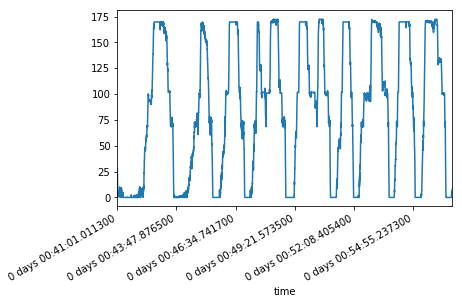

In [10]:
linear_position_df.linear_distance.plot();

In [11]:
distance = linear_position_df.linear_distance.values

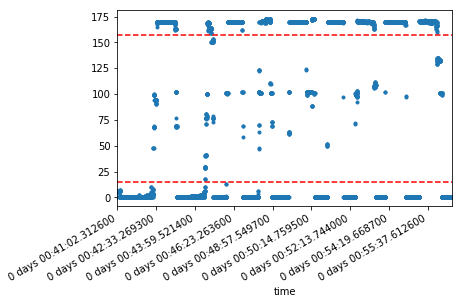

In [12]:
ax = linear_position_df.linear_distance.loc[position_df.speed < 1].plot(linestyle='None', marker='.')
ax.axhline(distance.max() - 15, color='red', linestyle='--')
ax.axhline(distance.min() + 15, color='red', linestyle='--')

In [13]:
distance.min(), distance.max()

(0.0, 172.3091881546892)

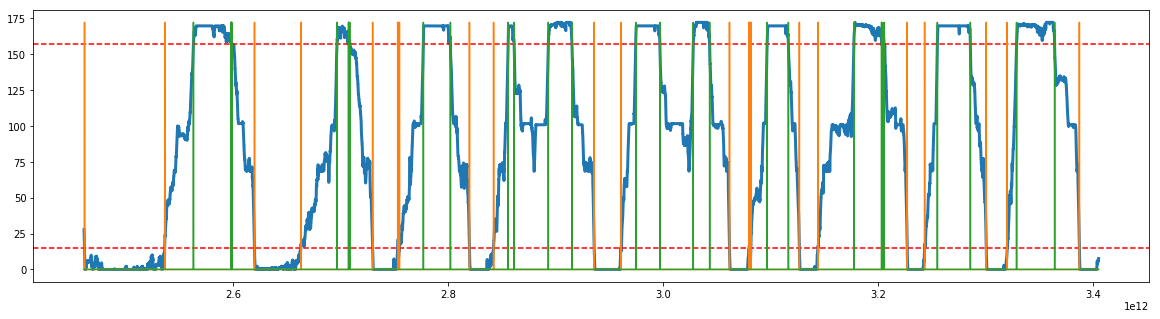

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(linear_position_df.index.values, linear_position_df.linear_distance.values, linewidth=3)
ax.axhline(distance.max() - 15, color='red', linestyle='--')
ax.axhline(distance.min() + 15, color='red', linestyle='--')
ax.plot(linear_position_df.index.values,
         distance.max() * np.abs(np.r_[0, np.diff(np.sign(distance - 15))]) / 2)

ax.plot(linear_position_df.index.values,
         distance.max() * np.abs(np.r_[0, np.diff(np.sign(distance - (distance.max() - 15)))]) / 2)

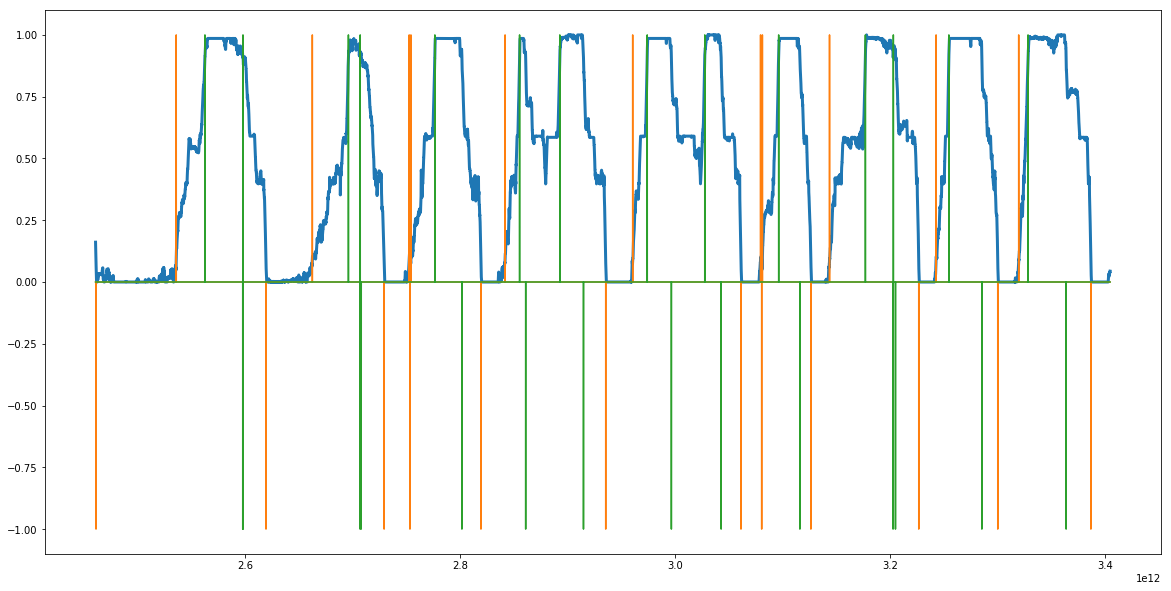

In [15]:
def threshold_crossings(x, threshold=0):
    return np.r_[0, np.diff(np.sign(x - threshold))]

plt.figure(figsize=(20, 10))
plt.plot(linear_position_df.index.values, linear_position_df.linear_distance.values / linear_position_df.linear_distance.max(), linewidth=3)
plt.plot(linear_position_df.index.values, threshold_crossings(distance, 15) / 2)
plt.plot(linear_position_df.index.values, threshold_crossings(distance, distance.max() - 15) / 2)

In [16]:
np.stack((np.abs(threshold_crossings(distance, 15)),
          np.abs(threshold_crossings(distance, distance.max() - 15))))

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

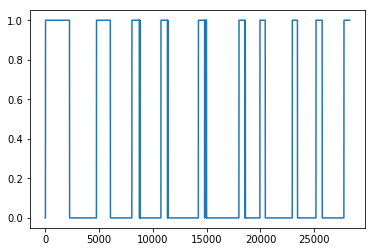

In [17]:
import scipy.spatial.distance
x = np.atleast_2d(np.array([217.649, 139.8246]))
d = scipy.spatial.distance.cdist(np.stack((position_df.x_position, position_df.y_position), axis=1), x) < 15

plt.plot(d.squeeze())

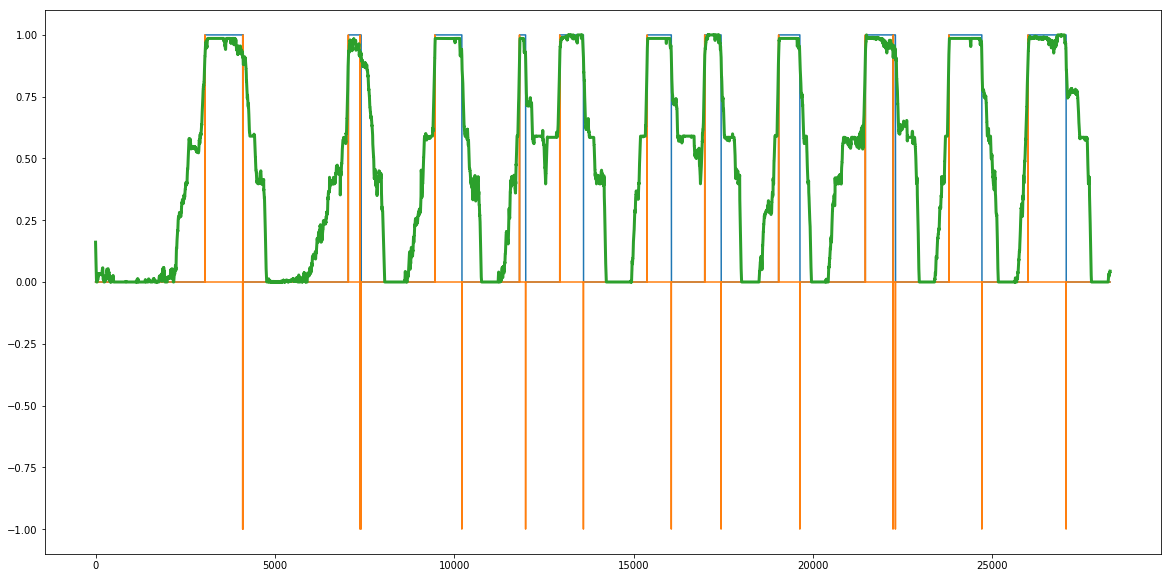

In [18]:
d = scipy.spatial.distance.cdist(np.array([distance.max()])[:, np.newaxis], np.atleast_2d(distance).T) < 15

plt.figure(figsize=(20, 10))
plt.plot(d.squeeze())
plt.plot(np.diff(d.squeeze() * 1))
plt.plot(linear_position_df.linear_distance.values / linear_position_df.linear_distance.max(), linewidth=3)

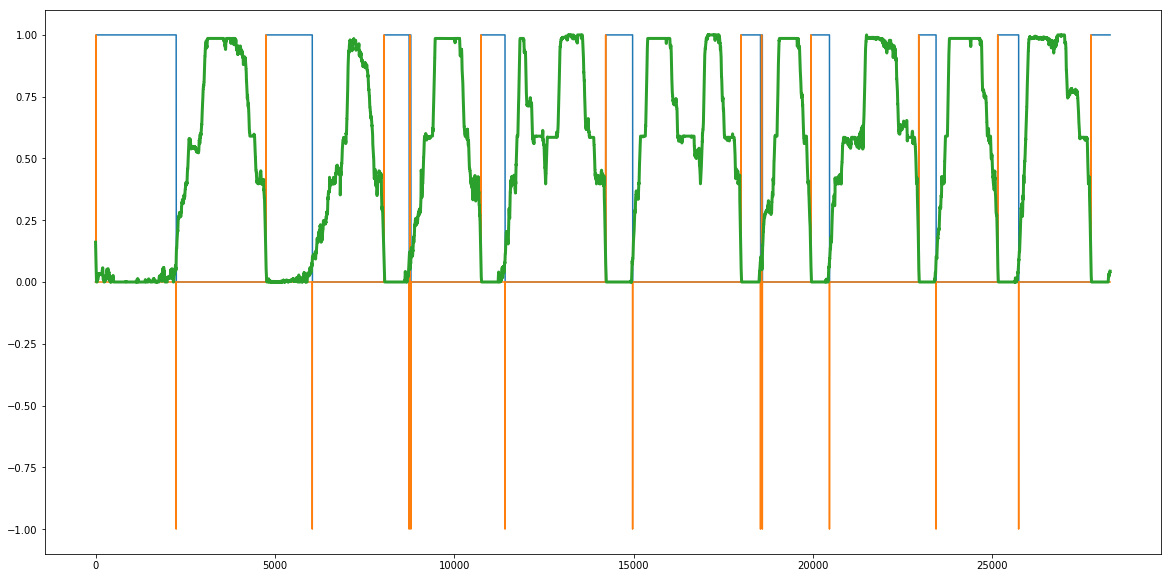

In [19]:
d = scipy.spatial.distance.cdist(np.array([0])[:, np.newaxis], np.atleast_2d(distance).T) < 15

plt.figure(figsize=(20, 10))
plt.plot(d.squeeze())
plt.plot(np.diff(d.squeeze() * 1))
plt.plot(linear_position_df.linear_distance.values / linear_position_df.linear_distance.max(), linewidth=3)

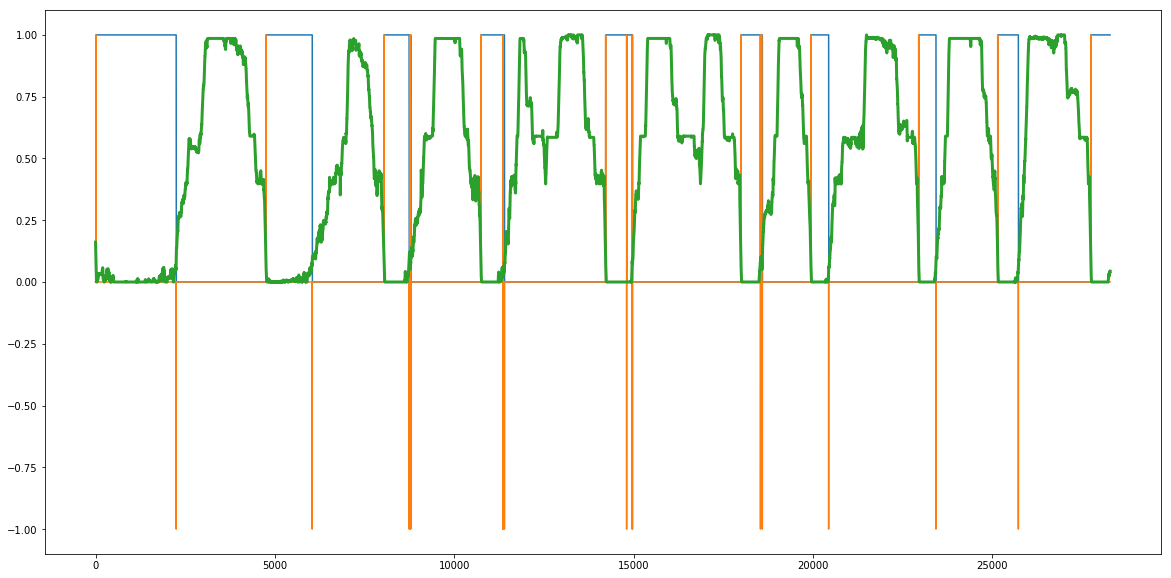

In [20]:
x = np.atleast_2d(np.array([217.649, 139.8246]))
d = scipy.spatial.distance.cdist(np.stack((position_df.x_position, position_df.y_position), axis=1), x) < 15

plt.figure(figsize=(20, 10))
plt.plot(d.squeeze())
plt.plot(np.diff(d.squeeze() * 1))
plt.plot(linear_position_df.linear_distance.values / linear_position_df.linear_distance.max(), linewidth=3)

In [95]:
from scipy.spatial.distance import cdist

def paired_distances(x, y):
    x, y = np.array(x), np.array(y)
    x = np.atleast_2d(x).T if x.ndim < 2 else x
    y = np.atleast_2d(y).T if y.ndim < 2 else y
    return np.linalg.norm(x - y, axis=1)
    

def enter_exit_target(position, target, max_distance=1):
    '''
     1: enter
     0: neither
    -1: exit
    '''
    distance_from_target = paired_distances(position, target)
    at_target = distance_from_target < max_distance
    enter_exit = np.r_[0, np.diff(at_target.astype(float))]
    return enter_exit

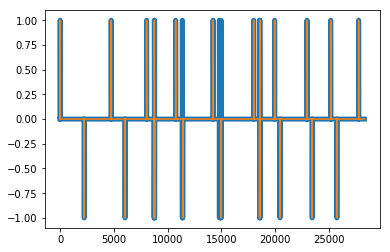

In [96]:
xy = np.stack((position_df.x_position, position_df.y_position), axis=1)
plt.plot(enter_exit_target(xy, np.atleast_2d(np.array([217.649, 139.8246])), max_distance=15), linewidth=5)
plt.plot(enter_exit_target(distance, 0, max_distance=15))

In [24]:
from scipy.ndimage.measurements import label

well_locations = np.array([0, distance.max()])
n_wells = len(well_locations)
enter_exit = np.stack(
    [enter_exit_target(distance, well, max_distance=15)
     for well in well_locations], axis=1)

well_labels = np.arange(n_wells) + 1
enter_exit = np.sum(enter_exit * well_labels, axis=1)
is_segment = ~(np.cumsum(enter_exit) > 0)
labeled_segments, n_segment_labels = label(is_segment)
segment_labels = np.arange(n_segment_labels) + 1

def shift_well_enters(enter_exit):
    shifted_enter_exit = enter_exit.copy()
    old_ind = np.where(enter_exit > 0)[0] # positive entries are well-entries
    new_ind = old_ind - 1
    shifted_enter_exit[new_ind], shifted_enter_exit[old_ind] = enter_exit[old_ind], 0
    return shifted_enter_exit

shifted_enter_exit = shift_well_enters(enter_exit)
shifted_enter_exit[labeled_segments == 5]

array([-1.,  0.,  0., ...,  0.,  0.,  2.])

,start_time,end_time,duration,from_well,to_well,distance_traveled
segment,,,,,,
1,0 days 00:41:01.011300,0 days 00:41:01.411700,0 days 00:00:00.400400,NaN,NaN,12.1828
2,0 days 00:42:16.085600,0 days 00:42:42.745400,0 days 00:00:26.659800,1,2,246.517
3,0 days 00:43:17.946900,0 days 00:43:18.147100,0 days 00:00:00.200200,2,2,0.979449
4,0 days 00:43:18.313900,0 days 00:43:39.568300,0 days 00:00:21.254400,2,1,223.17
5,0 days 00:44:22.711000,0 days 00:44:56.244200,0 days 00:00:33.533200,1,2,421.291
6,0 days 00:45:07.121600,0 days 00:45:07.221700,0 days 00:00:00.100100,2,2,0
7,0 days 00:45:08.189300,0 days 00:45:29.477100,0 days 00:00:21.287800,2,1,264.707
8,0 days 00:45:52.833500,0 days 00:45:53.500900,0 days 00:00:00.667400,1,1,10.1889
9,0 days 00:45:54.435100,0 days 00:46:16.690500,0 days 00:00:22.255400,1,2,276.489


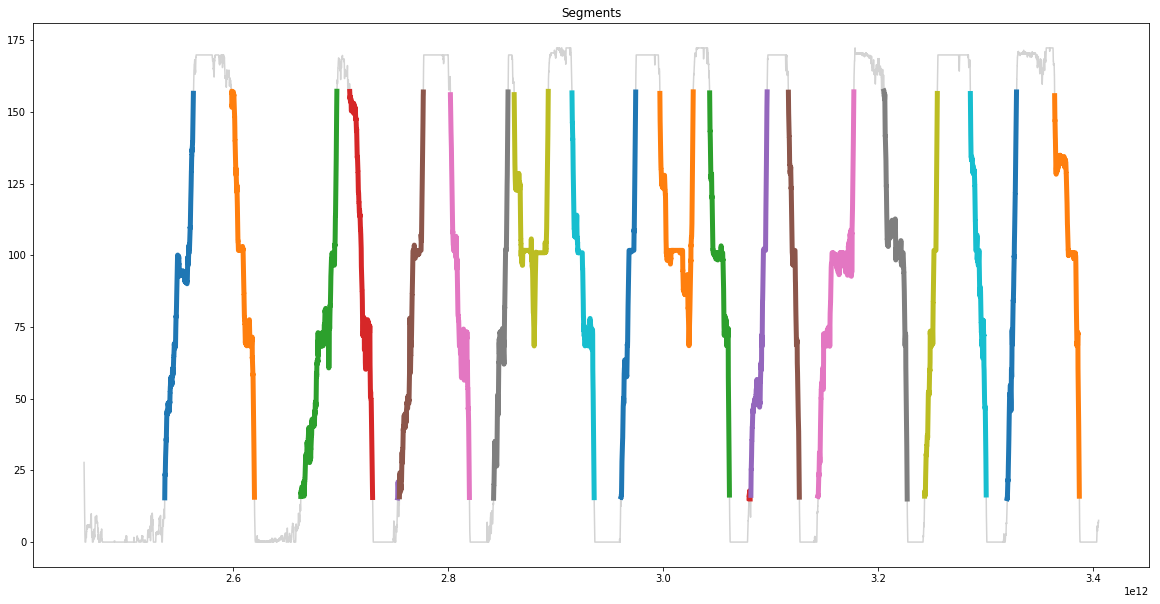

In [145]:
plt.figure(figsize=(20, 10))
plt.plot(time, distance, color='lightgrey')

time = position_df.index
start_time, end_time, duration, distance_traveled, from_well, to_well = [], [], [], [], [], []

for segment_label in segment_labels:
    is_seg = np.in1d(labeled_segments, segment_label)
    segment_time = time[is_seg]
    start_time.append(segment_time.min())
    end_time.append(segment_time.max())
    duration.append(segment_time.max() - segment_time.min())
    try:
        start, _, end = np.unique(shifted_enter_exit[is_seg])
    except ValueError:
        start, end = np.nan, np.nan
    from_well.append(np.abs(start))
    to_well.append(np.abs(end))
    d = distance[is_seg]
    distance_traveled.append(np.sum(paired_distances(d[1:], d[:-1])))
    if (distance_traveled[-1] > 5) & ~(np.isnan(from_well[-1]) | np.isnan(to_well[-1])):
        plt.plot(time[is_seg], distance[is_seg], linewidth=5)

plt.title('Segments')

s = pd.DataFrame(np.array([start_time, end_time, duration, from_well, to_well, distance_traveled]).T,
             columns=['start_time', 'end_time', 'duration', 'from_well', 'to_well', 'distance_traveled'],
            index=pd.Index(segment_labels, name='segment'))
display(s)

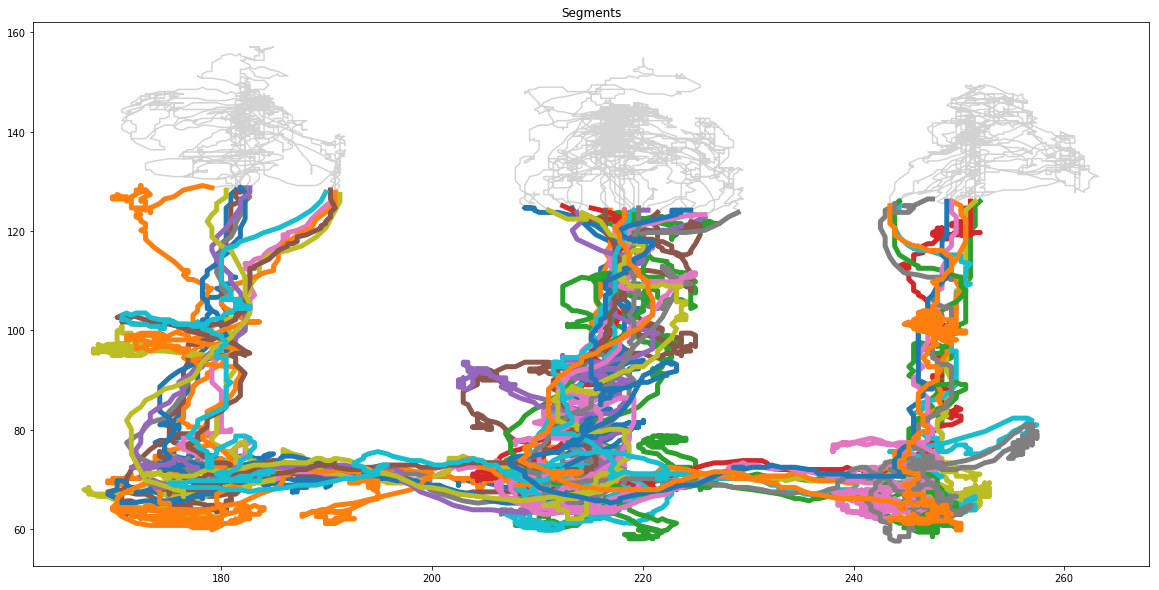

In [147]:
plt.figure(figsize=(20, 10))
plt.plot(xy[:, 0], xy[:, 1], color='lightgrey')

time = position_df.index
start_time, end_time, duration, distance_traveled, from_well, to_well = [], [], [], [], [], []

for segment_label in segment_labels:
    is_seg = np.in1d(labeled_segments, segment_label)
    segment_time = time[is_seg]
    start_time.append(segment_time.min())
    end_time.append(segment_time.max())
    duration.append(segment_time.max() - segment_time.min())
    try:
        start, _, end = np.unique(shifted_enter_exit[is_seg])
    except ValueError:
        start, end = np.nan, np.nan
    from_well.append(np.abs(start))
    to_well.append(np.abs(end))
    d = distance[is_seg]
    distance_traveled.append(np.sum(paired_distances(d[1:], d[:-1])))
    if (distance_traveled[-1] > 5) & ~(np.isnan(from_well[-1]) | np.isnan(to_well[-1])):
        plt.plot(xy[is_seg, 0], xy[is_seg, 1], linewidth=5)

plt.title('Segments');

In [855]:
well_locations = get_well_locations(epoch_key, ANIMALS)
xy = np.stack((position_df.x_position, position_df.y_position), axis=1)
time = position_df.index
segments_df, labeled_segments = segment_path(
    position.index, xy, well_locations)
segments_df = score_inbound_outbound(segments_df).loc[:, ['from_well', 'to_well', 'task', 'is_correct']]

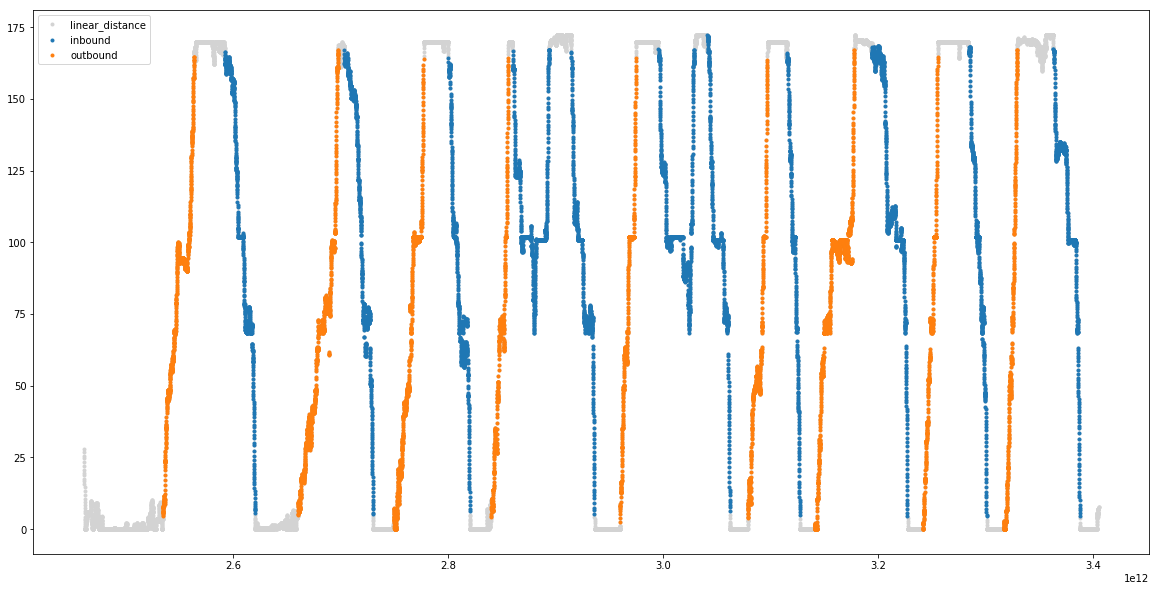

In [887]:
position = (pd.concat(
    [get_linear_position_structure(epoch_key, ANIMALS),
     get_position_dataframe(epoch_key, ANIMALS)], axis=1)
     .drop('trajectory_category_ind', axis=1)
)

well_locations = get_well_locations(epoch_key, ANIMALS)
xy = np.stack((position.x_position, position.y_position), axis=1)
segments_df, labeled_segments = segment_path(
    position.index, xy, well_locations, max_distance_from_well=5)
segments_df = score_inbound_outbound(segments_df).loc[
    :, ['from_well', 'to_well', 'task', 'is_correct']]

segments_df = pd.merge(
    labeled_segments, segments_df, right_index=True,
    left_on='labeled_segments', how='outer')
position = pd.concat((position, segments_df), axis=1)


plt.figure(figsize=(20, 10))
plt.plot(position.index, position.linear_distance, color='lightgrey', linestyle='None', marker='.')
plt.plot(position.loc[position.task == 'inbound'].index, position.loc[position.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position.loc[position.task == 'outbound'].index, position.loc[position.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();


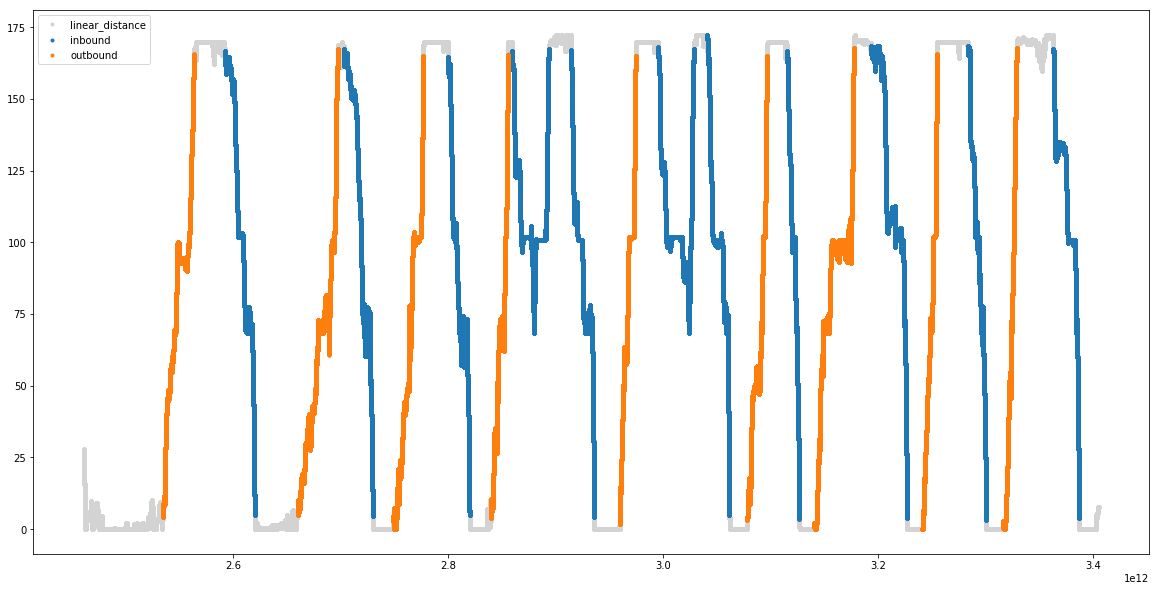

In [911]:
interp_position = get_interpolated_position_dataframe(epoch_key, ANIMALS)

plt.figure(figsize=(20, 10))
plt.plot(interp_position.index, interp_position.linear_distance, color='lightgrey', linestyle='None', marker='.')
plt.plot(interp_position.loc[interp_position.task == 'inbound'].index, interp_position.loc[interp_position.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(interp_position.loc[interp_position.task == 'outbound'].index, interp_position.loc[interp_position.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

/Users/edeno/miniconda3/envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


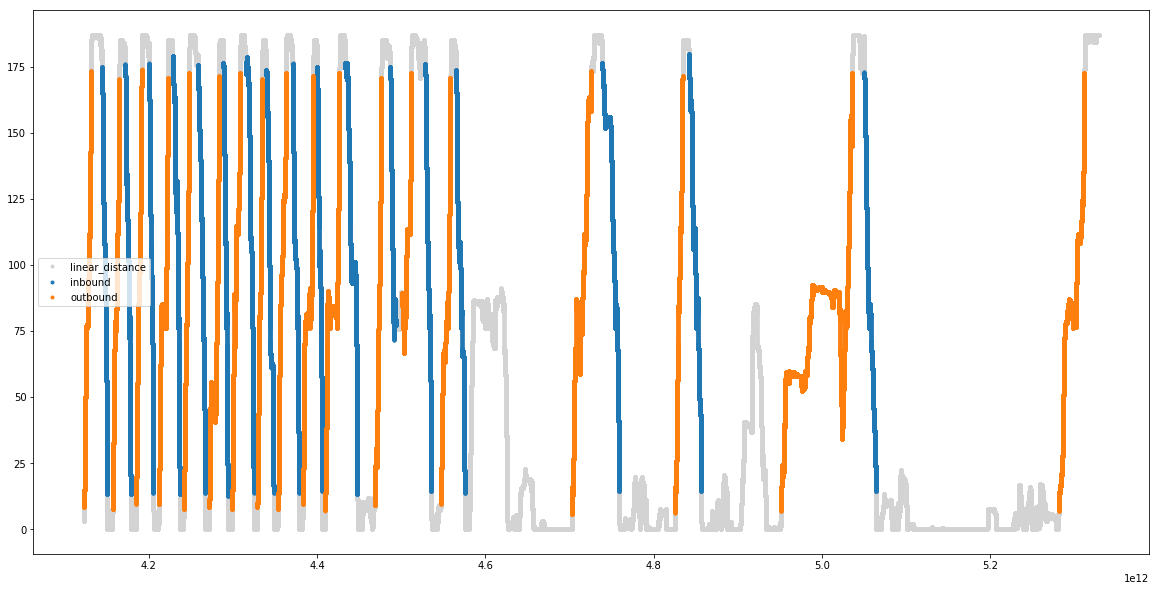

In [946]:
interp_position = get_interpolated_position_dataframe(('HPa', 6 , 2), ANIMALS, max_distance_from_well=15)

plt.figure(figsize=(20, 10))
plt.plot(interp_position.index, interp_position.linear_distance, color='lightgrey', linestyle='None', marker='.')
plt.plot(interp_position.loc[interp_position.task == 'inbound'].index, interp_position.loc[interp_position.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(interp_position.loc[interp_position.task == 'outbound'].index, interp_position.loc[interp_position.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

/Users/edeno/miniconda3/envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in less


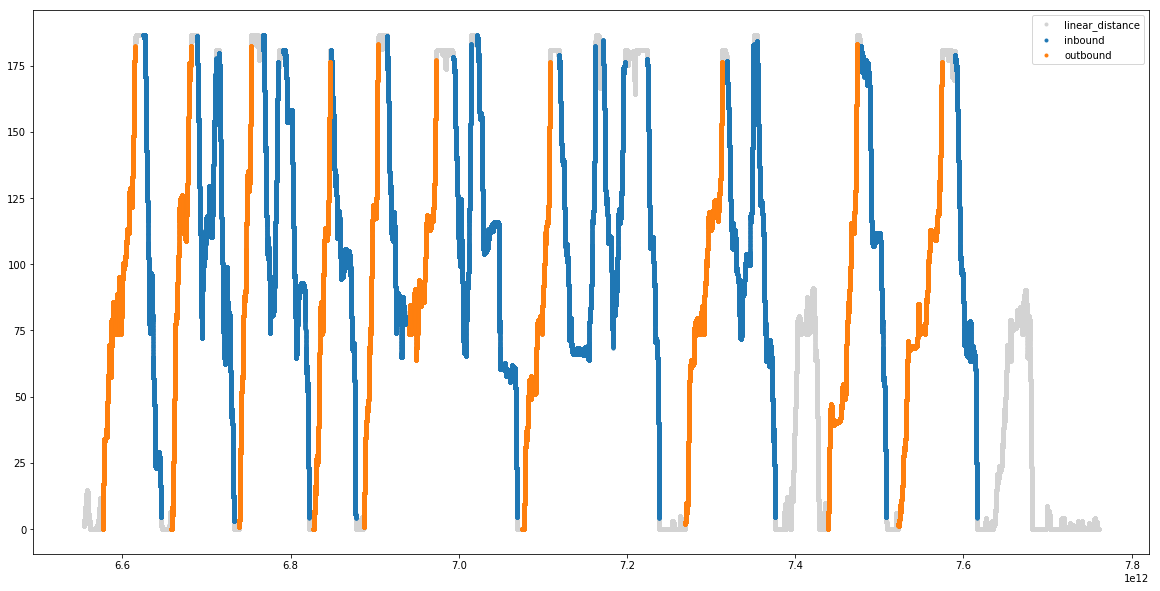

In [917]:
interp_position = get_interpolated_position_dataframe(('HPa', 6 , 4), ANIMALS, max_distance_from_well=15)

plt.figure(figsize=(20, 10))
plt.plot(interp_position.index, interp_position.linear_distance, color='lightgrey', linestyle='None', marker='.')
plt.plot(interp_position.loc[interp_position.task == 'inbound'].index, interp_position.loc[interp_position.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(interp_position.loc[interp_position.task == 'outbound'].index, interp_position.loc[interp_position.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

/Users/edeno/miniconda3/envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


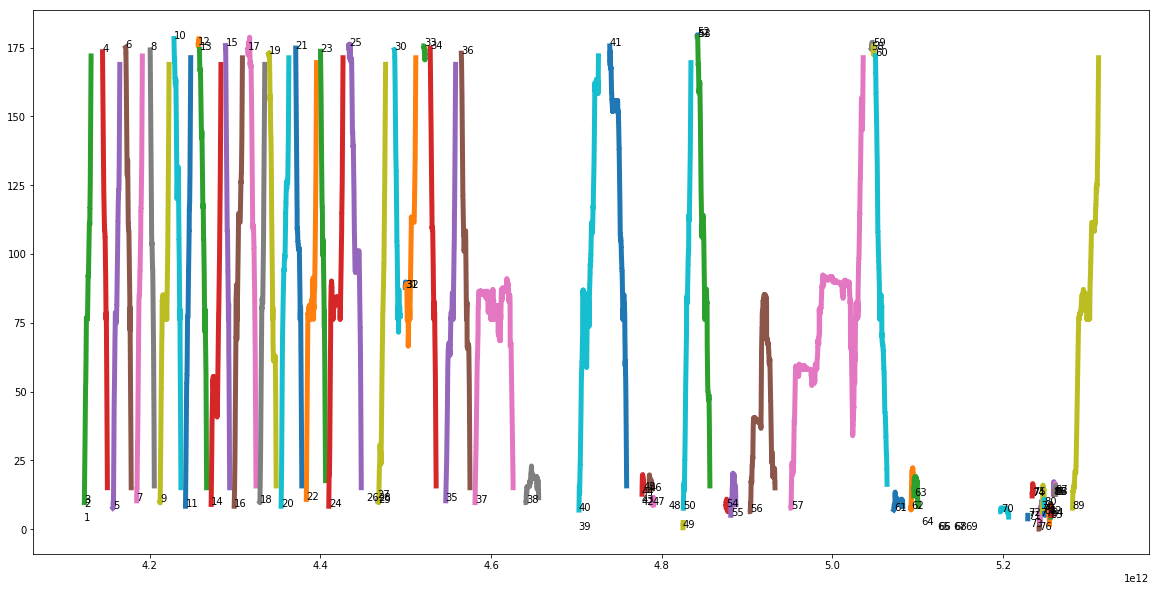

In [965]:
epoch_key = ('HPa', 6, 2)
position = (pd.concat(
    [get_linear_position_structure(epoch_key, ANIMALS),
     get_position_dataframe(epoch_key, ANIMALS)], axis=1)
     .drop('trajectory_category_ind', axis=1)
)
old_dt = (position.index[1] - position.index[0]).total_seconds()

well_locations = get_well_locations(epoch_key, ANIMALS)
xy = np.stack((position.x_position, position.y_position), axis=1)
segments_df, labeled_segments = segment_path(
    position.index, xy, well_locations,
    max_distance_from_well=15)

plt.figure(figsize=(20, 10))
for segment_label in np.unique(labeled_segments):
    if segment_label == 0:
        continue
    is_seg = np.in1d(labeled_segments, segment_label)
    plt.plot(position.index[is_seg], position.linear_distance[is_seg], linewidth=5)
    plt.text(position.index[is_seg].values[0], position.linear_distance[is_seg][0], str(segment_label))

In [967]:
segments_df.loc[30:32]

,start_time,end_time,duration,from_well,to_well,distance_traveled
segment,,,,,,
30,01:14:46.737700,01:14:53.743600,00:00:07.005900,3.0,1.0,192.060938
31,01:14:59.448200,01:14:59.948700,00:00:00.500500,1.0,1.0,4.438478
32,01:15:00.348900,01:15:11.758100,00:00:11.409200,1.0,2.0,247.163582


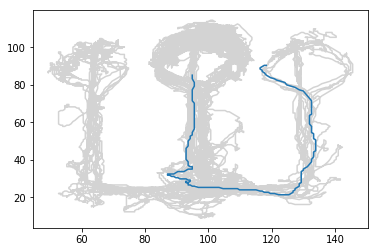

In [978]:
is_seg = labeled_segments.labeled_segments.isin([30])
plt.plot(position.x_position, position.y_position, color='lightgrey')
plt.plot(position.x_position[is_seg], position.y_position[is_seg])

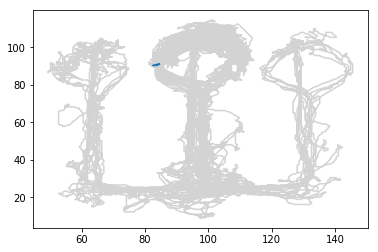

In [977]:
is_seg = labeled_segments.labeled_segments.isin([31])
plt.plot(position.x_position, position.y_position, color='lightgrey')
plt.plot(position.x_position[is_seg], position.y_position[is_seg])

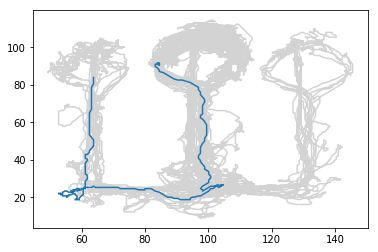

In [976]:
is_seg = labeled_segments.labeled_segments.isin([32])
plt.plot(position.x_position, position.y_position, color='lightgrey')
plt.plot(position.x_position[is_seg], position.y_position[is_seg])

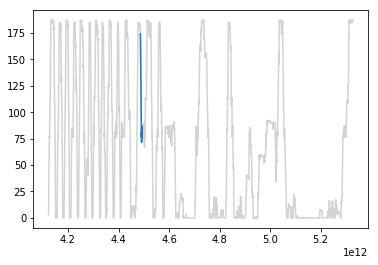

In [980]:
is_seg = labeled_segments.labeled_segments.isin([30])
plt.plot(position.linear_distance, color='lightgrey')
plt.plot(position.linear_distance[is_seg])

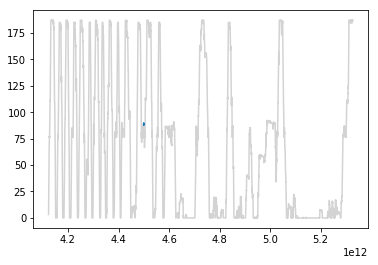

In [981]:
is_seg = labeled_segments.labeled_segments.isin([31])
plt.plot(position.linear_distance, color='lightgrey')
plt.plot(position.linear_distance[is_seg])

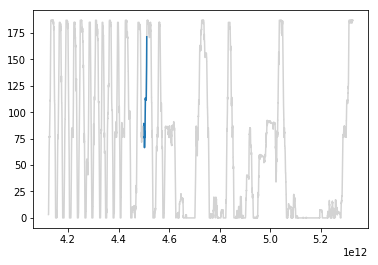

In [982]:
is_seg = labeled_segments.labeled_segments.isin([32])
plt.plot(position.linear_distance, color='lightgrey')
plt.plot(position.linear_distance[is_seg])

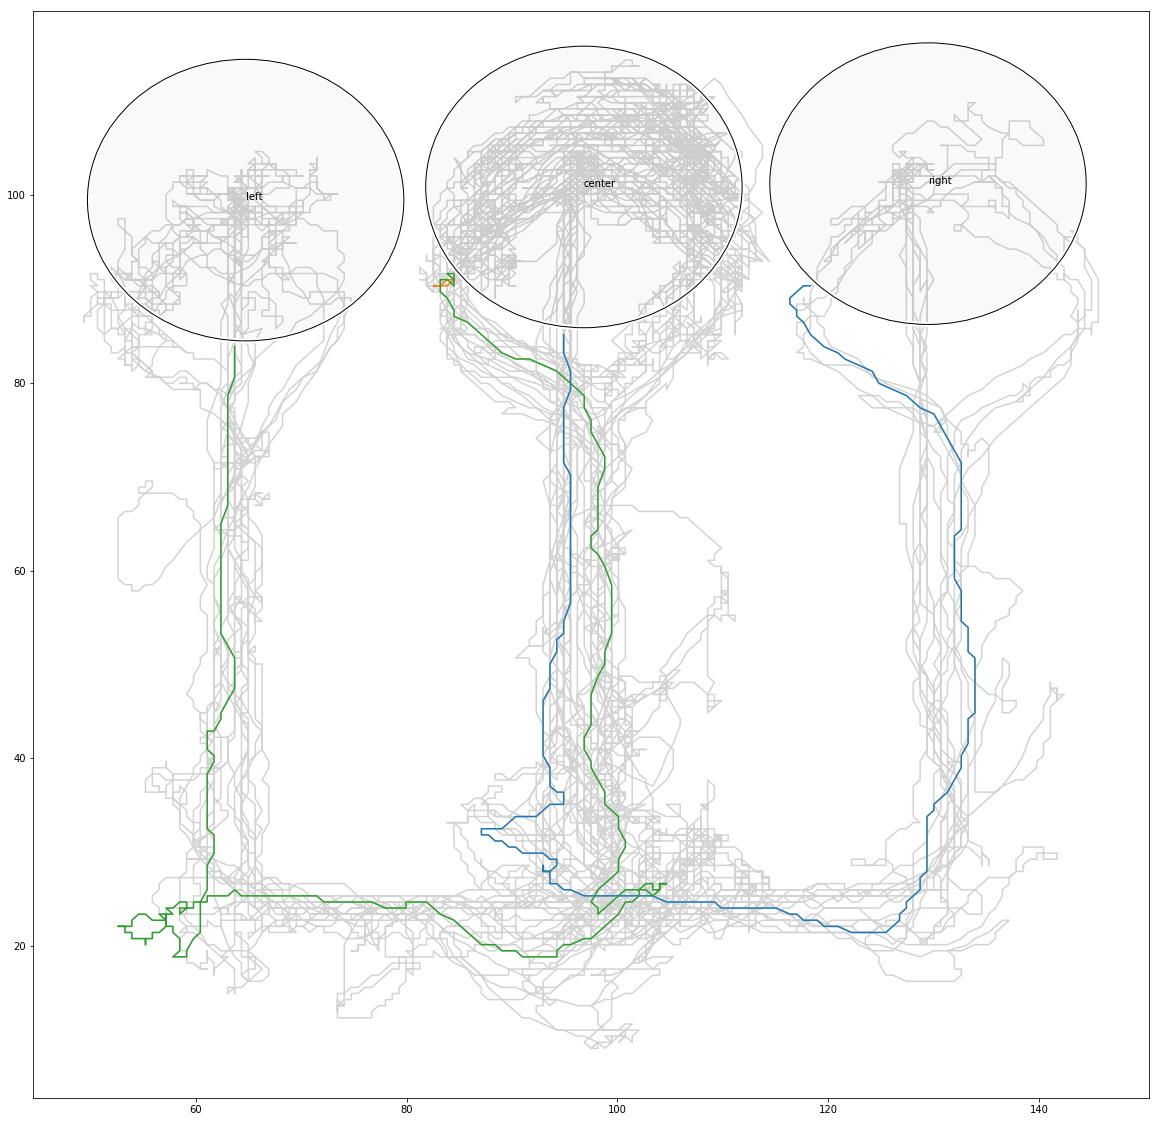

In [1015]:
plt.figure(figsize=(20, 20))
plt.plot(position.x_position, position.y_position, color='lightgrey')
plt.text(well_locations[0, 0], well_locations[0, 1], 'center')
plt.text(well_locations[1, 0], well_locations[1, 1], 'left')
plt.text(well_locations[2, 0], well_locations[2, 1], 'right')


def circle(x, y, radius=0.15, ax=None):
    from matplotlib.patches import Circle
    from matplotlib.patheffects import withStroke
    circle = Circle((x, y), radius, clip_on=False, zorder=10, linewidth=1,
                    edgecolor='black', facecolor=(0, 0, 0, .0125),
                    path_effects=[withStroke(linewidth=5, foreground='w')])
    if ax is None:
        ax = plt.gca()
    ax.add_artist(circle)
    
circle(well_locations[0, 0], well_locations[0, 1], radius=15)
circle(well_locations[1, 0], well_locations[1, 1], radius=15)
circle(well_locations[2, 0], well_locations[2, 1], radius=15)


is_seg = labeled_segments.labeled_segments.isin([30])
plt.plot(position.x_position[is_seg], position.y_position[is_seg])

is_seg = labeled_segments.labeled_segments.isin([31])
plt.plot(position.x_position[is_seg], position.y_position[is_seg])

is_seg = labeled_segments.labeled_segments.isin([32])
plt.plot(position.x_position[is_seg], position.y_position[is_seg])

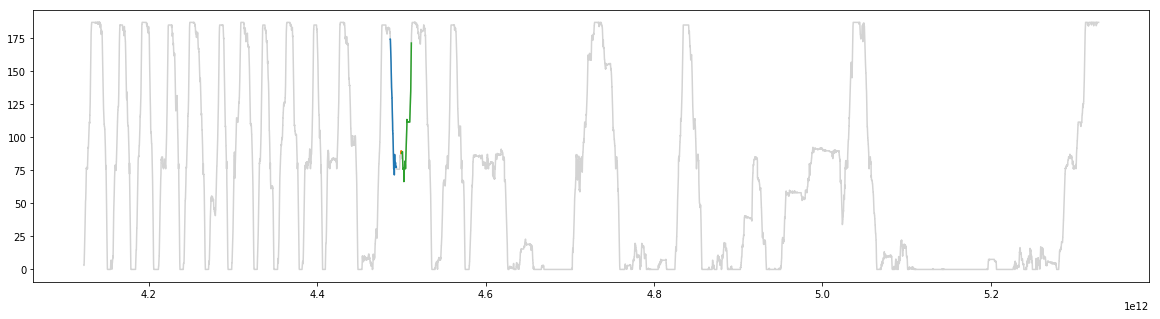

In [1017]:
plt.figure(figsize=(20, 5))
plt.plot(position.linear_distance, color='lightgrey')

is_seg = labeled_segments.labeled_segments.isin([30])
plt.plot(position.linear_distance[is_seg])

is_seg = labeled_segments.labeled_segments.isin([31])
plt.plot(position.linear_distance[is_seg])

is_seg = labeled_segments.labeled_segments.isin([32])
plt.plot(position.linear_distance[is_seg])

/Users/edeno/miniconda3/envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


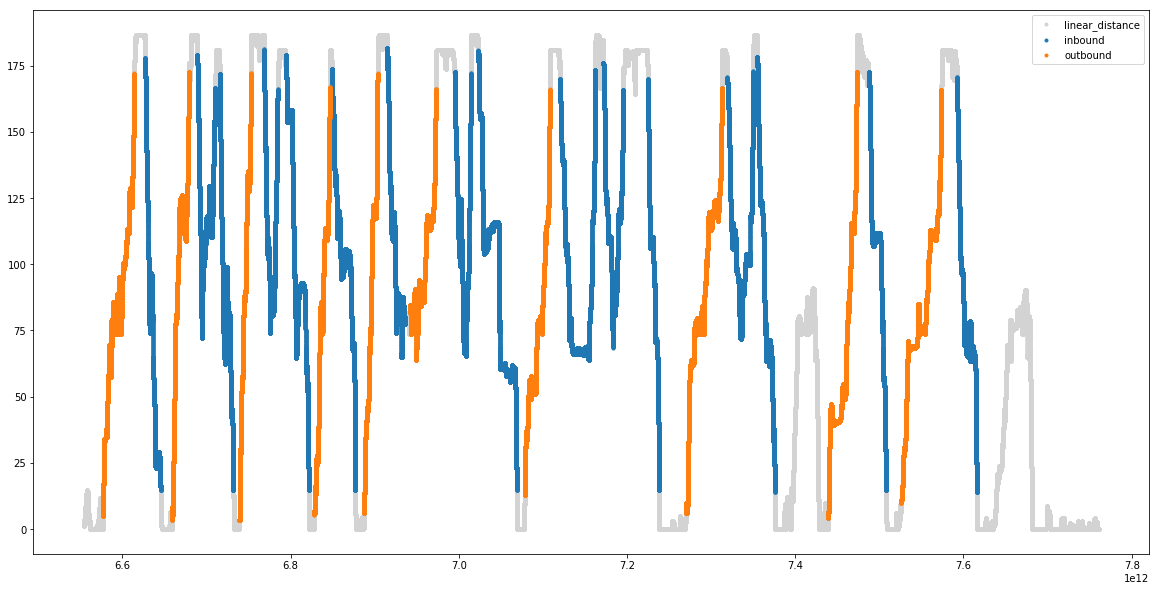

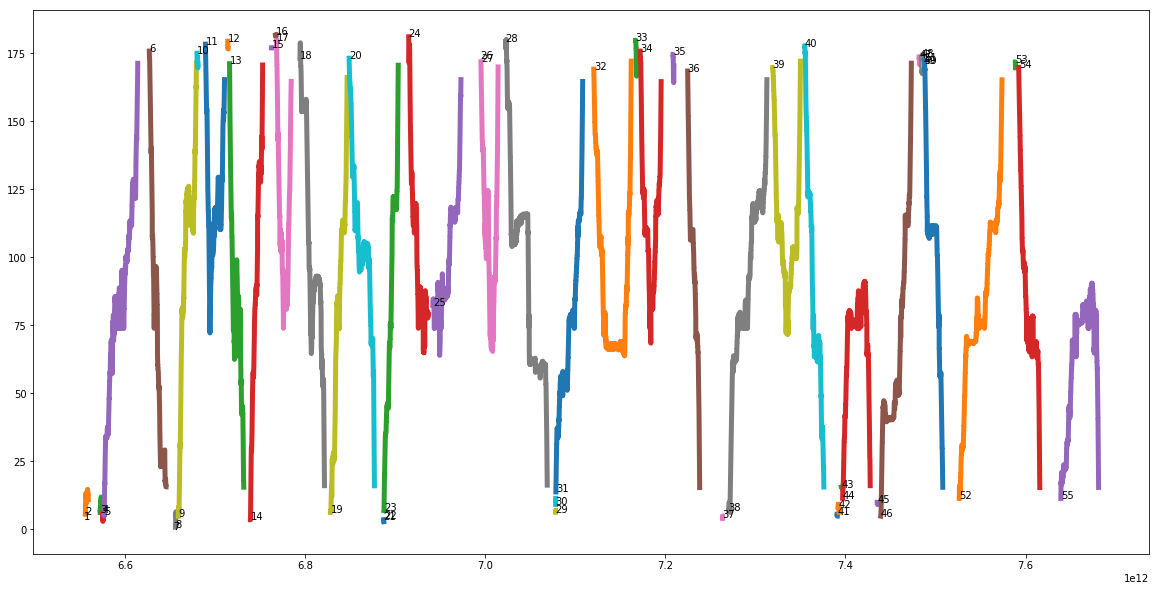

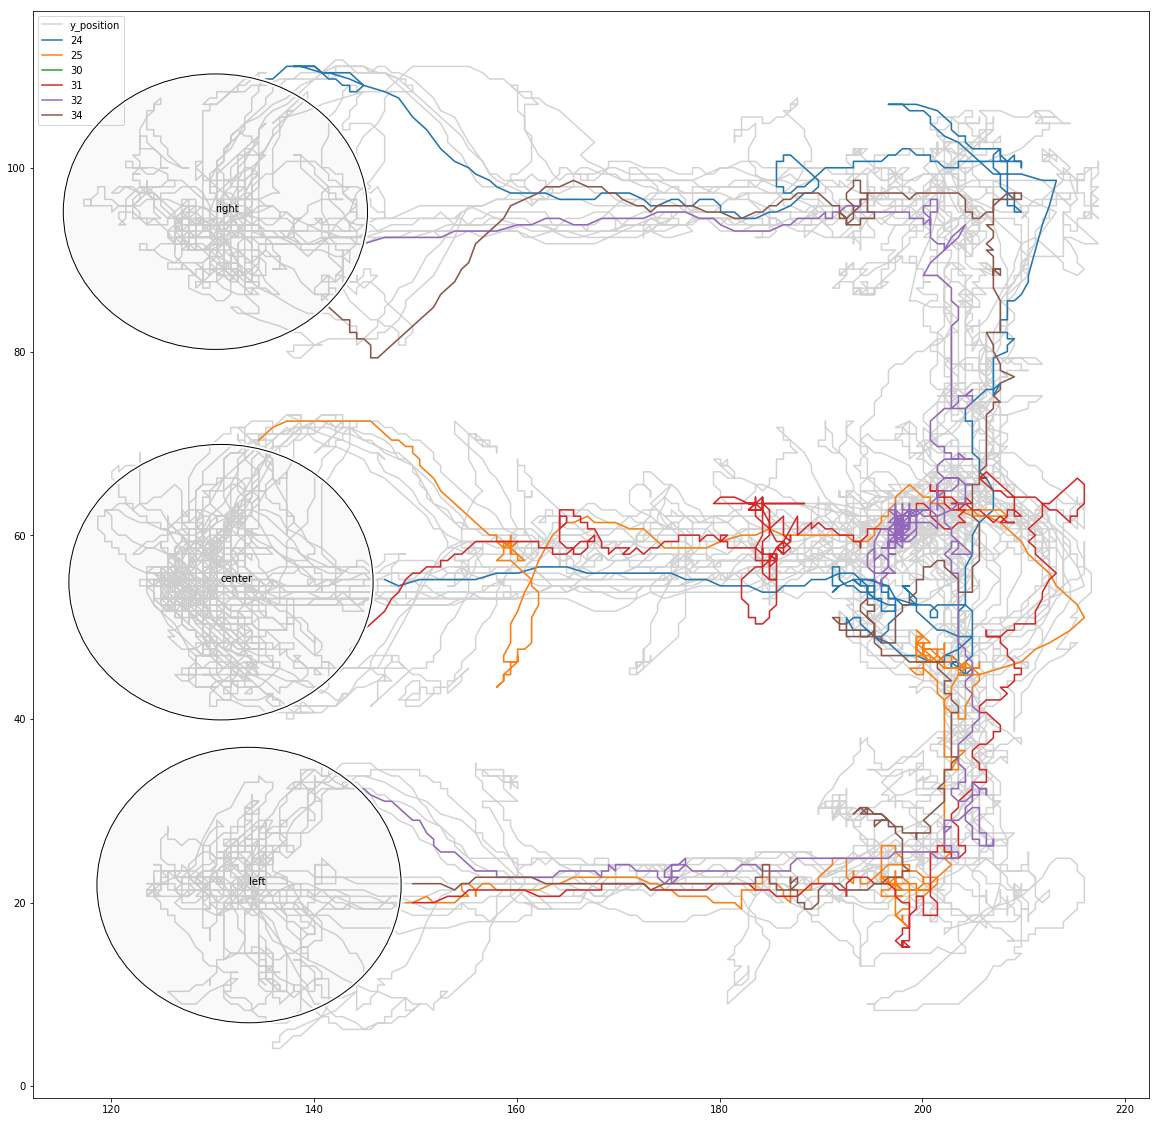

In [1027]:
epoch_key = ('HPa', 6, 4)

interp_position = get_interpolated_position_dataframe(epoch_key, ANIMALS, max_distance_from_well=15)

plt.figure(figsize=(20, 10))
plt.plot(interp_position.index, interp_position.linear_distance, color='lightgrey', linestyle='None', marker='.')
plt.plot(interp_position.loc[interp_position.task == 'inbound'].index, interp_position.loc[interp_position.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(interp_position.loc[interp_position.task == 'outbound'].index, interp_position.loc[interp_position.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

position = (pd.concat(
    [get_linear_position_structure(epoch_key, ANIMALS),
     get_position_dataframe(epoch_key, ANIMALS)], axis=1)
     .drop('trajectory_category_ind', axis=1)
)
old_dt = (position.index[1] - position.index[0]).total_seconds()

well_locations = get_well_locations(epoch_key, ANIMALS)
xy = np.stack((position.x_position, position.y_position), axis=1)
segments_df, labeled_segments = segment_path(
    position.index, xy, well_locations,
    max_distance_from_well=15)

plt.figure(figsize=(20, 10))
for segment_label in np.unique(labeled_segments):
    if segment_label == 0:
        continue
    is_seg = np.in1d(labeled_segments, segment_label)
    plt.plot(position.index[is_seg], position.linear_distance[is_seg], linewidth=5)
    plt.text(position.index[is_seg].values[0], position.linear_distance[is_seg][0], str(segment_label))

plt.figure(figsize=(20, 20))
plt.plot(position.x_position, position.y_position, color='lightgrey')
plt.text(well_locations[0, 0], well_locations[0, 1], 'center')
plt.text(well_locations[1, 0], well_locations[1, 1], 'left')
plt.text(well_locations[2, 0], well_locations[2, 1], 'right')


def circle(x, y, radius=0.15, ax=None):
    from matplotlib.patches import Circle
    from matplotlib.patheffects import withStroke
    circle = Circle((x, y), radius, clip_on=False, zorder=10, linewidth=1,
                    edgecolor='black', facecolor=(0, 0, 0, .0125),
                    path_effects=[withStroke(linewidth=5, foreground='w')])
    if ax is None:
        ax = plt.gca()
    ax.add_artist(circle)
    
circle(well_locations[0, 0], well_locations[0, 1], radius=15)
circle(well_locations[1, 0], well_locations[1, 1], radius=15)
circle(well_locations[2, 0], well_locations[2, 1], radius=15)


for seg in [24, 25, 30, 31, 32, 34]:
    is_seg = labeled_segments.labeled_segments.isin([seg])
    plt.plot(position.x_position[is_seg], position.y_position[is_seg], label=str(seg), linewidth=4)

plt.legend();

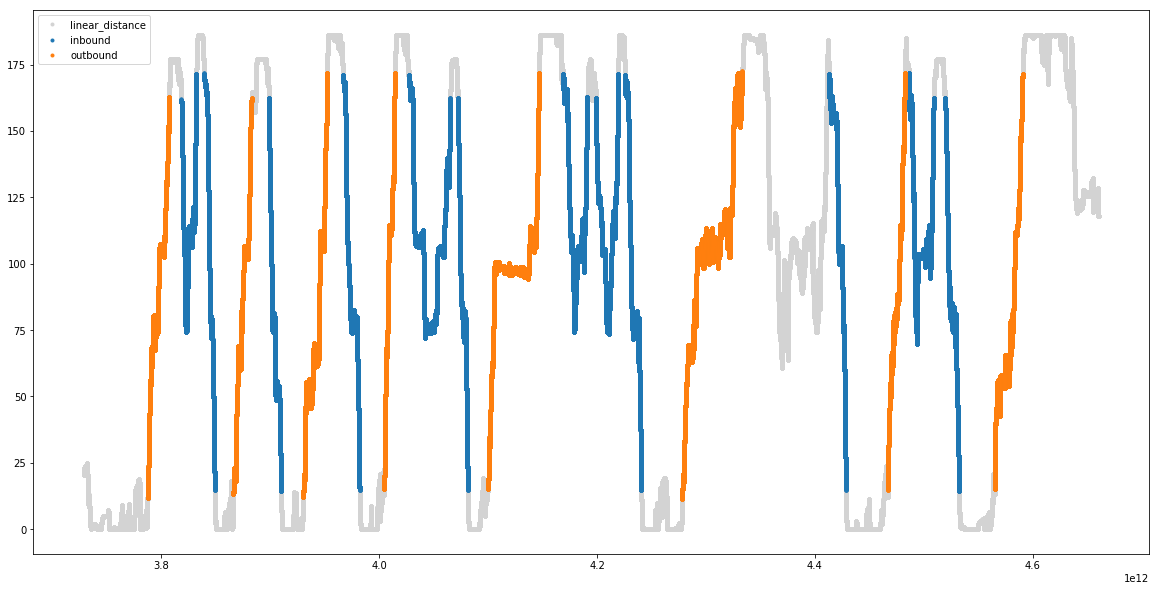

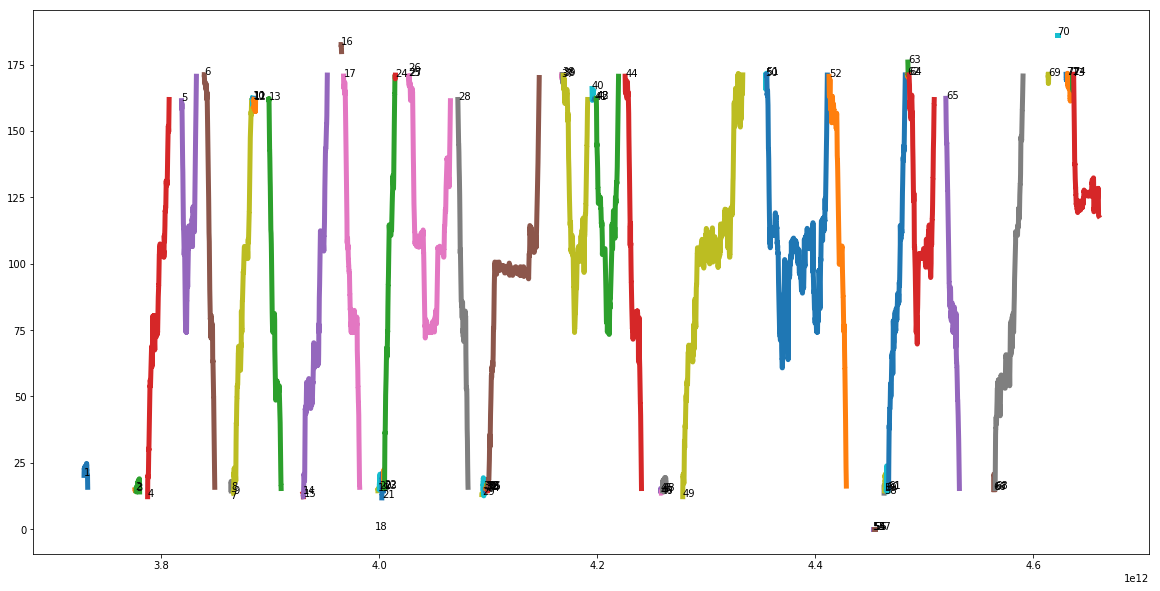

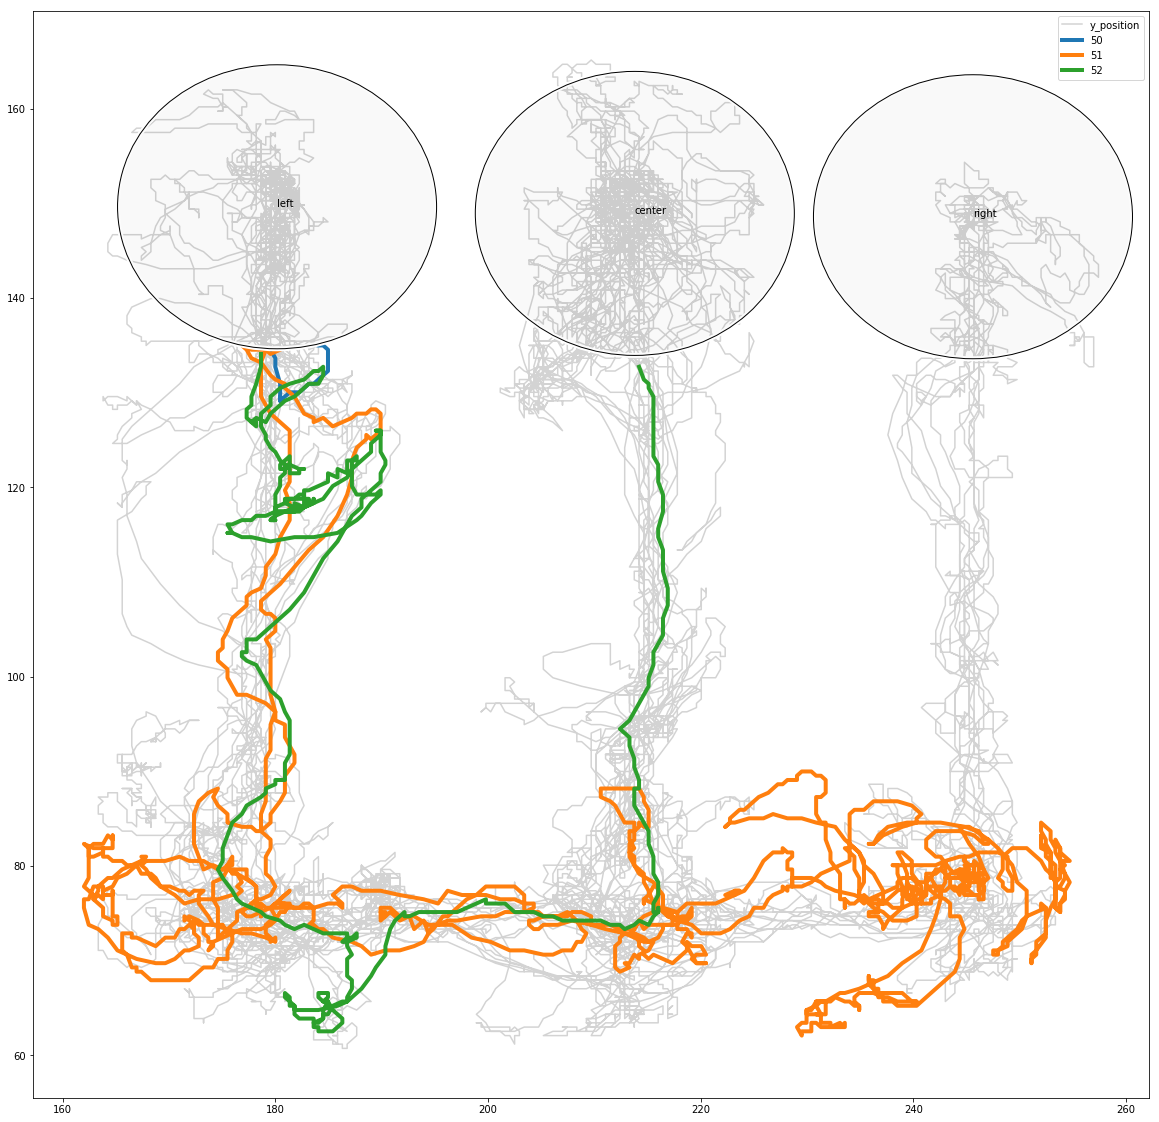

In [1032]:
epoch_key = ('bon', 3, 2)

interp_position = get_interpolated_position_dataframe(epoch_key, ANIMALS, max_distance_from_well=15)

plt.figure(figsize=(20, 10))
plt.plot(interp_position.index, interp_position.linear_distance, color='lightgrey', linestyle='None', marker='.')
plt.plot(interp_position.loc[interp_position.task == 'inbound'].index, interp_position.loc[interp_position.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(interp_position.loc[interp_position.task == 'outbound'].index, interp_position.loc[interp_position.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

position = (pd.concat(
    [get_linear_position_structure(epoch_key, ANIMALS),
     get_position_dataframe(epoch_key, ANIMALS)], axis=1)
     .drop('trajectory_category_ind', axis=1)
)
old_dt = (position.index[1] - position.index[0]).total_seconds()

well_locations = get_well_locations(epoch_key, ANIMALS)
xy = np.stack((position.x_position, position.y_position), axis=1)
segments_df, labeled_segments = segment_path(
    position.index, xy, well_locations,
    max_distance_from_well=15)

plt.figure(figsize=(20, 10))
for segment_label in np.unique(labeled_segments):
    if segment_label == 0:
        continue
    is_seg = np.in1d(labeled_segments, segment_label)
    plt.plot(position.index[is_seg], position.linear_distance[is_seg], linewidth=5)
    plt.text(position.index[is_seg].values[0], position.linear_distance[is_seg][0], str(segment_label))

plt.figure(figsize=(20, 20))
plt.plot(position.x_position, position.y_position, color='lightgrey')
plt.text(well_locations[0, 0], well_locations[0, 1], 'center')
plt.text(well_locations[1, 0], well_locations[1, 1], 'left')
plt.text(well_locations[2, 0], well_locations[2, 1], 'right')


def circle(x, y, radius=0.15, ax=None):
    from matplotlib.patches import Circle
    from matplotlib.patheffects import withStroke
    circle = Circle((x, y), radius, clip_on=False, zorder=10, linewidth=1,
                    edgecolor='black', facecolor=(0, 0, 0, .0125),
                    path_effects=[withStroke(linewidth=5, foreground='w')])
    if ax is None:
        ax = plt.gca()
    ax.add_artist(circle)
    
circle(well_locations[0, 0], well_locations[0, 1], radius=15)
circle(well_locations[1, 0], well_locations[1, 1], radius=15)
circle(well_locations[2, 0], well_locations[2, 1], radius=15)


for seg in np.arange(50, 53):
    is_seg = labeled_segments.labeled_segments.isin([seg])
    plt.plot(position.x_position[is_seg], position.y_position[is_seg], label=str(seg), linewidth=4)

plt.legend();